In [60]:
options(repr.plot.width  = 6, plot.height = 4)
options(jupyter.plot_mimetypes = "image/png");
library(tidyverse)
library(lubridate)
library(modelr)

# Lecture 20
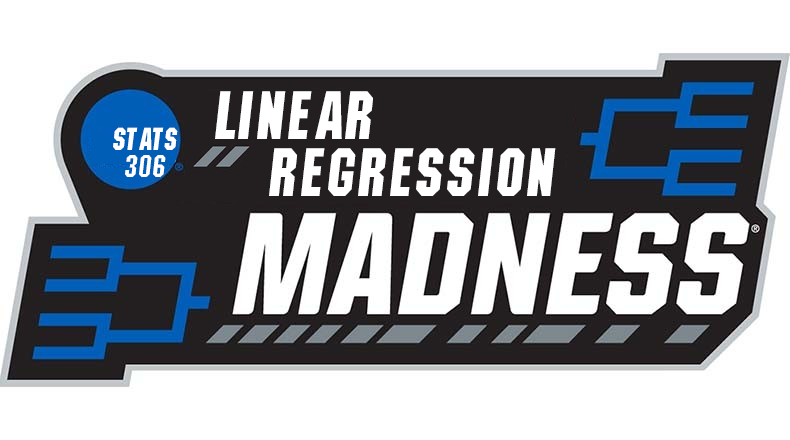

## NCAA data
The files in `data/` ([source](https://github.com/brendanlong/ncaa-predict)) represent 15 years of NCAA basketball data (players/schools/games):

In [3]:
dir("../ps9/ncaa/")

 [1] "ncaa_games_2002.csv.gz" "ncaa_games_2003.csv.gz" "ncaa_games_2004.csv.gz"
 [4] "ncaa_games_2005.csv.gz" "ncaa_games_2006.csv.gz" "ncaa_games_2007.csv.gz"
 [7] "ncaa_games_2008.csv.gz" "ncaa_games_2009.csv.gz" "ncaa_games_2010.csv.gz"
[10] "ncaa_games_2011.csv.gz" "ncaa_games_2012.csv.gz" "ncaa_games_2013.csv.gz"
[13] "ncaa_games_2014.csv.gz" "ncaa_games_2015.csv.gz" "ncaa_games_2016.csv.gz"
[16] "ncaa_games_2017.csv.gz" "ncaa_games_2018.csv.gz" "ncaa_games_2019.csv.gz"
[19] "ncaa_schools.csv.gz"   

In [128]:
schools <- read_csv("../ps9/ncaa/ncaa_schools.csv.gz")
games = str_c("../ps9/ncaa/ncaa_games_", 2002:2019, ".csv.gz") %>% map_dfr(read_csv) %>% 
        mutate(game_date = mdy(game_date)) %>% 
        inner_join(schools) %>%
        mutate(is_home = location == "Home",
               home_score = ifelse(is_home, score, opponent_score),
               away_score = ifelse(is_home, opponent_score, score),
               home_team = ifelse(is_home, school_name, opponent_name),
               away_team = ifelse(is_home, opponent_name, school_name))

Parsed with column specification:
cols(
  school_id = col_double(),
  school_name = col_character()
)
Parsed with column specification:
cols(
  opponent_name = col_character(),
  game_date = col_character(),
  score = col_double(),
  opponent_score = col_double(),
  location = col_character(),
  neutral_site_location = col_character(),
  game_length = col_character(),
  attendence = col_double(),
  opponent_id = col_double(),
  year = col_double(),
  school_id = col_double()
)
Parsed with column specification:
cols(
  opponent_name = col_character(),
  game_date = col_character(),
  score = col_double(),
  opponent_score = col_double(),
  location = col_character(),
  neutral_site_location = col_character(),
  game_length = col_character(),
  attendence = col_double(),
  opponent_id = col_double(),
  year = col_double(),
  school_id = col_double()
)
Parsed with column specification:
cols(
  opponent_name = col_character(),
  game_date = col_character(),
  score = col_double(),
  oppone

## Predicting success in the NCAA
We will use regression and modeling to predict which teams are most likely to succeed in March Madness.

First we will simply rank the schools by their margins:

In [103]:
games %>% mutate(margin = score - opponent_score) %>% group_by(school_name) %>% 
          summarize(m = mean(margin), n = n()) %>% top_n(25, m) %>% 
          arrange(desc(m))

   school_name          m         n  
1  West Liberty         14.715044 565
2  Amherst              14.049149 529
3  Gonzaga              13.632520 615
4  Wooster              13.204007 549
5  Duke                 13.080745 644
6  Kansas               12.576923 650
7  Findlay              12.183601 561
8  Whitworth            12.051690 503
9  Southern Ind.        11.769643 560
10 Williams             11.638132 514
11 Wis.-Stevens Point   11.578244 524
12 Tarleton St.         11.233743 569
13 St. Thomas (MN)      10.966990 515
14 MSU Denver           10.805263 570
15 Oakland City         10.584646 508
16 Kentucky             10.550702 641
17 Louisville           10.519108 628
18 Walsh                10.350877 228
19 North Carolina       10.239502 643
20 Florida              10.231861 634
21 Northwest Mo. St.    10.167539 573
22 Washington-St. Louis  9.964730 482
23 Randolph-Macon        9.669922 512
24 Ky. Wesleyan          9.616236 542
25 Penn St.-Behrend      9.564663 549

The highest ranking schools include several of the top D1 programs as well as some smaller schools. We don't have the NCAA division recorded in these data, but can use attendance to pick out the large D1 schools.

In [105]:
top_schools = games %>% mutate(margin = score - opponent_score) %>% group_by(school_id) %>% 
                        summarize(m = sum(attendence)) %>% inner_join(schools) %>% 
                        top_n(20, m) %>% arrange(desc(m)) %>% print

Joining, by = "school_id"


# A tibble: 20 x 3
   school_id        m school_name       
       <dbl>    <dbl> <chr>             
 1       334 12465692 Kentucky          
 2       688 11604828 Syracuse          
 3       457 10833829 North Carolina    
 4       367 10617557 Louisville        
 5       328 10192544 Kansas            
 6       416  9469203 Michigan St.      
 7       796  9459703 Wisconsin         
 8       518  9126489 Ohio St.          
 9       306  8882040 Indiana           
10       301  8704233 Illinois          
11       392  8618973 Maryland          
12       694  8531429 Tennessee         
13       193  8497348 Duke              
14       490  8081829 North Carolina St.
15       387  7930954 Marquette         
16       418  7709854 Michigan          
17       235  7706129 Florida           
18       164  7690604 UConn             
19       703  7584775 Texas             
20        29  7559127 Arizona           


In [106]:
games_top = games %>% semi_join(top_schools) %>% print

Joining, by = c("school_id", "school_name")


# A tibble: 12,431 x 17
   opponent_name game_date  score opponent_score location neutral_site_lo…
   <chr>         <date>     <dbl>          <dbl> <chr>    <chr>           
 1 Maryland      2001-11-08    71             67 Neutral  New York        
 2 Florida       2001-11-09    75             71 Neutral  New York        
 3 Texas         2001-11-17    88             74 Away     <NA>            
 4 Kansas        2001-12-01    97            105 Home     <NA>            
 5 Illinois      2001-12-04    87             82 Neutral  Phoenix, AZ     
 6 Purdue        2001-12-08    79             66 Neutral  Anaheim, CA     
 7 Michigan St.  2001-12-15    60             74 Away     <NA>            
 8 Oregon St.    2001-12-20    76             73 Away     <NA>            
 9 Oregon        2001-12-22    75            105 Away     <NA>            
10 Pepperdine    2001-12-28    94             71 Home     <NA>            
# ... with 12,421 more rows, and 11 more variables: game_length <chr>,
#   a

## Ranking the teams: logistic regression MCMC
We will use a model called [logistic regression MCMC](https://pdfs.semanticscholar.org/bb21/8ea8e16cc43afb7f50eefc0bea4b0fd35ff1.pdf) to build rankings for the NCAA teams. The basic model is as follows:
- We imagine that there is an imaginary person whose job it is to vote on the best team. 
- The voter picks a random team as the best to begin with, and then iterates the following procedure: 
    - Given that the voter currently believes that team $A$ is the best, she picks a random game that team $A$ played versus some team $B$. 
    - With probability $p$, the voter decides that the winner of $A$ vs. $B$ is the new best team, and with probability $(1-p)$ the voter decides that the *loser* is the new best team.

Suppose team $i$ played $N_i$ games in total. Let $w_{ij},l_{ij}$ be the number of games that $i$ won/lost against team $j$. The probability that our voter goes from thinking that $i$ is the best team, to thinking that $j$ is the best team, is 

$$M_{ij} =\frac{1}{N_i}[w_{ij}(1-p) + l_{ij}(p)].$$

A moment's thought suggests that the probability $p$ should not necessarily be fixed. Indeed, it should be high if team $A$ was "clearly better" than team $B$, whereas if $A$ just "barely beat" team $B$ then it should be close to 1/2.

In this model the probability $p$ will be a function of the *point spread* between teams $A$ and $B$. Specifically, $p$ is the probability that a team that outscores its opponent by $x$ points at home is better than its opponent. This way, very small point spreads can correspond to $p \approx 1/2$ -- it's a tossup which team is better in this scenario.

## Logistic regression model
In order to implement this model, we need a way to estimate 

$$\mathbb{P}(\text{Team A will beat team B on a neutral court}\mid \text{Team A's home margin vs. Team B was $x$ points}).$$

That is, we want to estimate a function $f(x)$ that returns this probability. 

## Logistic regression
In all of the regressions we have seen so far, the dependent ($y$) variable has been continuous: life expectancy, price, etc. However, there are many situations where the outcome is categorical. For simplicity, we will assume it's binary, and can be coded as 0/1. How should we model binary data?

One idea is to just stick what we know and use the linear model. Will this work?

In [56]:
mdl <- lm(I(price > 1000) ~ carat, data = diamonds)
summary(mdl)


Call:
lm(formula = I(price > 1000) ~ carat, data = diamonds)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0679 -0.4545  0.1183  0.3181  0.5733 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.287986   0.003011   95.63   <2e-16 ***
carat       0.554868   0.003245  171.01   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3572 on 53938 degrees of freedom
Multiple R-squared:  0.3516,	Adjusted R-squared:  0.3516 
F-statistic: 2.924e+04 on 1 and 53938 DF,  p-value: < 2.2e-16


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


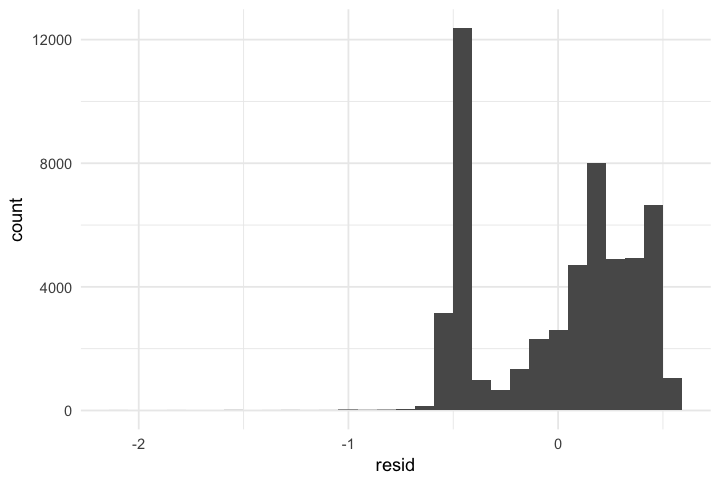

In [57]:
diamonds %>% add_residuals(mdl) %>% mutate(resid=as.numeric(resid)) %>% 
     ggplot + geom_histogram(aes(x=resid))

The linear model is fundamentally wrong for categorical outcomes, because the normal distribution is not discrete. (Note that categorical covariates are fine.) 

The linear model says:

$$y = f(a + b x)$$ 

for $f(x)=x$. For 0/1 outcomes, let's instead try to think probabilistically:

$$\text{Prob}(y=1) = \underbrace{f(a + b x)}_{(\text{some function of the covariates})}$$

What criteria should this function $f$ have?
- It's range needs to be $[0,1]$.
- For "extreme" values of $a + bx$ it should tend to zero one one.

The function we will use, for various technical reasons, is called the **logistic function**:
$$f(x) = \frac{1}{1 + e^{-x}}.$$

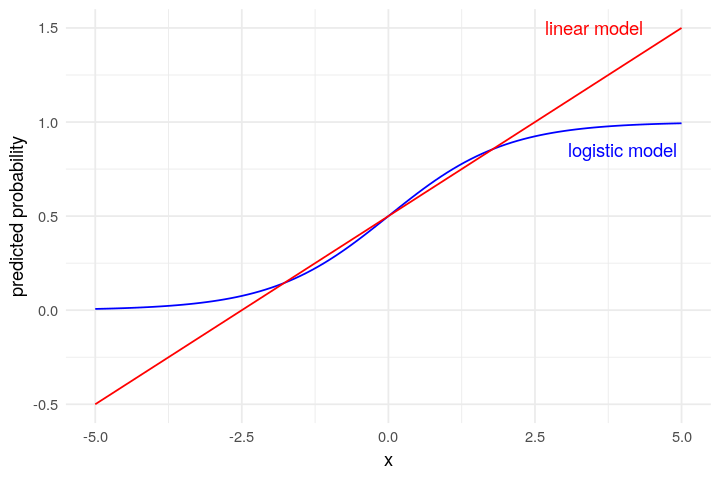

Let's re-do our model fitting and residual diagnostics using this model. We run the logistic regression using the `glm()` command. This has the same syntax as the `lm()` command. The key difference is the `family = "binomial"` option, which tells R that our dependent variable is binary instead of continuous.

In [58]:
mdl <- glm(I(price > 10000) ~ carat, data=diamonds, family="binomial")
summary(mdl)


Call:
glm(formula = I(price > 10000) ~ carat, family = "binomial", 
    data = diamonds)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.6303  -0.2201  -0.0459  -0.0217   2.7322  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -10.5461     0.1250  -84.37   <2e-16 ***
carat         6.8379     0.0882   77.53   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 34308  on 53939  degrees of freedom
Residual deviance: 12308  on 53938  degrees of freedom
AIC: 12312

Number of Fisher Scoring iterations: 8


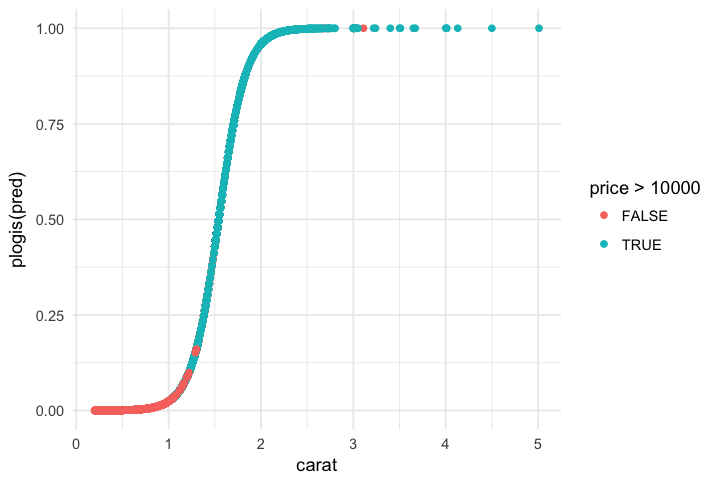

In [59]:
diamonds %>% add_predictions(mdl) %>% ggplot + geom_point(aes(x=carat, y=plogis(pred), 
                                                              color=price > 10000))

Returning to the NCAA problem at hand, we'll create a dataset of pairs of games. Most conference teams play each other twice per season, once at each campus. We'll look at the outcome of one of the games and use it to predict the outcome of the second game according to the above model.

### Exercise
Construct a dataset consisting of game pairs (teams which played each other twice during the season.)

In [136]:
# Your code here
game_pairs <- inner_join(games, games, by = c("home_team" = "away_team",
                                              "away_team" = "home_team",
                                              "year")) %>% 
              filter(game_date.x != game_date.y) %>% 
              mutate(home_margin = home_score.x - away_score.x,
                     beat_on_road = away_score.y > home_score.y) %>%
              distinct(home_team, away_team, year, home_margin, beat_on_road)

In [140]:
game_pairs[c(1,3),]

  year home_team          away_team          home_margin beat_on_road
1 2002 A&M-Corpus Christi San Francisco      5           FALSE       
2 2002 San Francisco      A&M-Corpus Christi 2           FALSE       

In [145]:
game_pairs[c(6,10),]

  year home_team          away_team          home_margin beat_on_road
1 2002 Tex.-Pan American  A&M-Corpus Christi -7          TRUE        
2 2002 A&M-Corpus Christi Tex.-Pan American  -5          TRUE        

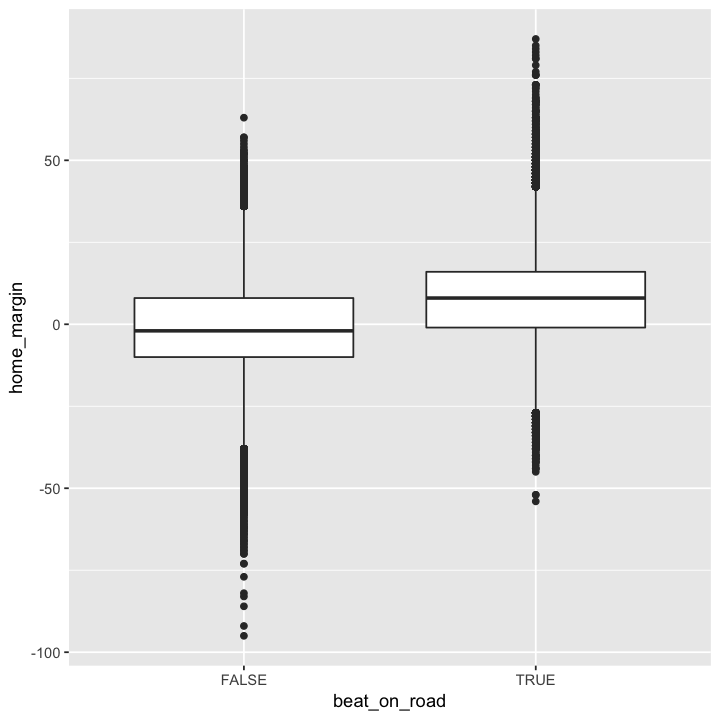

In [148]:
ggplot(game_pairs, aes(x = beat_on_road, y = home_margin)) + geom_boxplot()

Recall that we want to estimate 

$$\mathbb{P}(\text{Team A will beat team B on a neutral court}\mid \text{Team A's home margin vs. Team B was $x$ points}).$$

But we do not observe how the teams will fare when playing on a neutral court. We will instead estimate the observable event "A beat B at B's home court".

In [149]:
model = glm(beat_on_road ~ home_margin, data = game_pairs, family = "binomial")
summary(model)


Call:
glm(formula = beat_on_road ~ home_margin, family = "binomial", 
    data = game_pairs)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4257  -1.0183  -0.6946   1.1366   2.6174  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.4937505  0.0052380  -94.26   <2e-16 ***
home_margin  0.0536746  0.0004007  133.94   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 253971  on 186203  degrees of freedom
Residual deviance: 232477  on 186202  degrees of freedom
AIC: 232481

Number of Fisher Scoring iterations: 4


Let's see how well our logistic regression model fits to data:

In [172]:
predictions <- game_pairs %>% group_by(home_margin) %>% 
    summarize(p_win = mean(beat_on_road), sdp = sd(beat_on_road)) %>%
    add_predictions(model) %>% mutate(pred = plogis(pred))

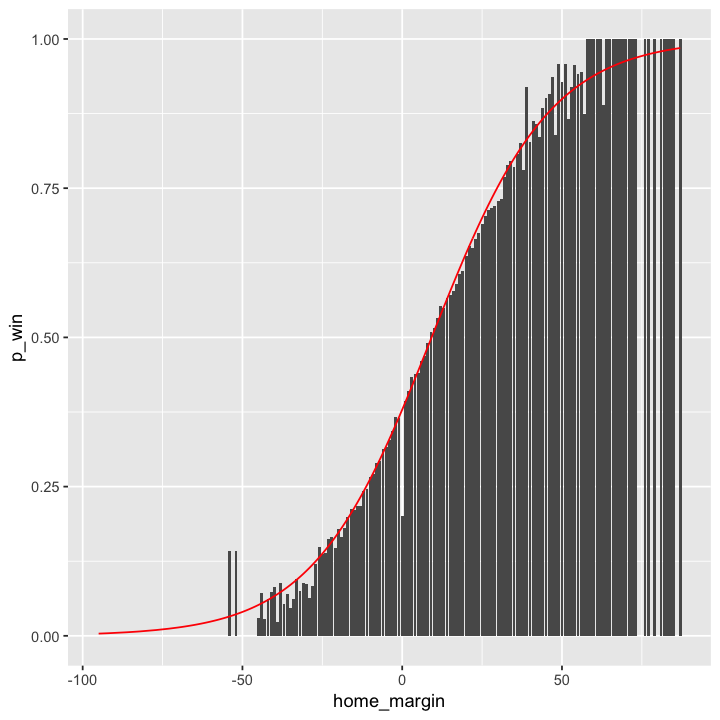

In [173]:
predictions %>% 
    ggplot(aes(x = home_margin)) + 
    geom_col(aes(y = p_win)) + 
    geom_line(aes(y = pred), color = "red")

To estimate

$$\mathbb{P}(\text{Team A will beat team B on a neutral court}\mid \text{Team A's home margin vs. Team B was $x$ points})$$

we will subtract from team A's home margin the "home court advantage."

The home court advantage $h$ is the average point spread bonus given to the home team. We can estimate this by finding the home point spread that leads to 50/50 odds of winning the away game. 

In [178]:
beta = coef(model)
(h = -beta[1] / beta[2])
r_H = function(x) plogis(beta %*% c(1, x + h))

(Intercept) 
   9.198957 

Finally we construct our voter model. In technical terms this is a Markov chain, and we can calculate its long-run probabilities by building a Markov matrix $M$. Each entry $M_{ij}$ of the matrix corresponds to a pair of teams, and equals the probability, estimated by our logistic regression model, that team $i$ beats team $j$.

In [227]:
sc <- unique(games$opponent_name)
n <- length(sc)
M <- matrix(data = 0, nrow = n, ncol = n)
rownames(M) <- sc
colnames(M) <- rownames(M)
N <- vector("integer", length = n)
names(N) = sc

In [231]:
# this takes a while
for (k in 1:nrow(games)) {
    row = games[k, ]
    i <- row$school_name
    j <- row$opponent_name
    margin <- row$score - row$opponent_score
    p <- r_H(margin)
    win <- row$score > row$opponent_score
    M[i, j] <- M[i, j] + (p * win) + (1 - p) * (1 - win)
    p <- r_H(-margin)
    M[j, i] <- M[j, i] + p * (1 - win) + (1 - p) * win
    N[i] <- N[i] + 1
    N[j] <- N[j] + 1
}

In [124]:
#for (s in sids) {
#    df = games_nona %>% filter(school_id == s)
#    if (nrow(df) > 0)
#        M[s,] = f(df)
#    M[s, s] = 1. - sum(M[s, ])
#}
#save(M, file = "M.RData")
load("M.RData")
M[1:10, 1:10]

      26172        2          929       3         4           721        
26172 0.4914306475 0.00373781 0.0000000 0.0000000 0.000000000 0.003263067
2     0.0121407261 0.42810189 0.0000000 0.0000000 0.000000000 0.000000000
929   0.0000000000 0.00000000 0.4898049 0.0000000 0.000000000 0.000000000
3     0.0000000000 0.00000000 0.0000000 0.5544908 0.000000000 0.000000000
4     0.0000000000 0.00000000 0.0000000 0.0000000 0.472928030 0.000000000
721   0.0015266403 0.00000000 0.0000000 0.0000000 0.000000000 0.508527130
5     0.0000000000 0.00000000 0.0000000 0.0000000 0.000106806 0.000000000
10    0.0000000000 0.00000000 0.0000000 0.0000000 0.000000000 0.000000000
8     0.0005201934 0.00000000 0.0000000 0.0000000 0.000000000 0.000000000
6     0.0000000000 0.00000000 0.0000000 0.0000000 0.000000000 0.000000000
      5           10          8           6          
26172 0.000000000 0.000000000 0.001889988 0.000000000
2     0.000000000 0.000000000 0.000000000 0.000000000
929   0.000000000 0.0000

In [159]:
# Remove degenerate rows
degen = near(diag(M), 1)
Md = M[!degen, !degen]
library(expm)
p = (Md %^% 2000)[1,]
p = p / sum(p)

In [163]:
tibble(p=p, school_id=as.integer(names(p))) %>% inner_join(schools) %>% arrange(desc(p))

Joining, by = "school_id"


     p            school_id school_name      
1    0.004973881  328       Kansas           
2    0.004855945  193       Duke             
3    0.004360657  457       North Carolina   
4    0.004278211  367       Louisville       
5    0.004202822  334       Kentucky         
6    0.004179964  796       Wisconsin        
7    0.004041282  235       Florida          
8    0.003927163   29       Arizona          
9    0.003922857  518       Ohio St.         
10   0.003878620  545       Pittsburgh       
11   0.003853608  416       Michigan St.     
12   0.003836726  688       Syracuse         
13   0.003682808  703       Texas            
14   0.003619073  739       Villanova        
15   0.003616595  404       Memphis          
16   0.003597346  164       UConn            
17   0.003513297  260       Gonzaga          
18   0.003474083  513       Notre Dame       
19   0.003466045  392       Maryland         
20   0.003295458  559       Purdue           
21   0.003294893  110       UCLA  